# Adversarial attack on MNIST Classifier

This notebook aims to show how one can attack a simple image classifier using a few noisy images. We will make use of Fast Gradient Sign Attack, by Goodfellow et. al (2014). Before executing the notebook, ensure that GPU is enabled. You can do so by clicking on Runtime and "Change Runtime Type" and setting Hardware acceleration to GPU.

**We first start by loading the MNIST dataset into the system**

In [1]:
from keras.datasets import mnist
(train_X,train_Y), (test_X,test_Y) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


**Let's check the shape of the dataset and unique classes in the dataset**

In [2]:
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

print('Training data shape : ', train_X.shape, train_Y.shape)

print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (60000, 28, 28) (60000,)
Testing data shape :  (10000, 28, 28) (10000,)


In [3]:
classes = np.unique(train_Y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


**Let''s display a few examples from the Test dataset to show what our data feels like**

Text(0.5,1,'Ground Truth : 7')

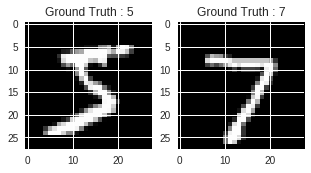

In [4]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

**We reshape the dataset since CNN's require 4D-tensors as input, where 4th dimension is the number of channels. In our case, it is one since the MNIST images are not RGB**

In [5]:
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)
train_X.shape, test_X.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

**We now do further preprocessing by coercing the training and test data to float32 type and normalizing the images by dividing them with 255**

In [0]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X / 255.
test_X = test_X / 255.

**Since our labels are numeric and CNNs require binary vectors for training, we convert the labels into One-hot encoded vectors**

In [7]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


**We split the training data into training and validation data, which will be useful for hyperparameter tuning and to help tune model better**

In [0]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.1, random_state=13)

In [9]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((54000, 28, 28, 1), (6000, 28, 28, 1), (54000, 10), (6000, 10))

# CNN Model creation

**We now create our model. We first import the required functions for creating the model.**

In [0]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

**This initializes the values for Batch size and Epochs for training purposes**

In [0]:
batch_size = 64
epochs = 10
num_classes = 10

**We now create our CNN model here. The model is inspired by Tensorflow tutorial on MNIST**

In [0]:
mnist_model = Sequential()
mnist_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',padding='same',input_shape=(28,28,1)))
mnist_model.add(MaxPooling2D((2, 2),padding='same'))
mnist_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
mnist_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
mnist_model.add(Flatten())
mnist_model.add(Dense(128, activation='linear'))
mnist_model.add(Dense(num_classes, activation='softmax'))

**The model is compiled using Cross-Entropy Loss and Adam optimizer**

In [0]:
mnist_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [14]:
mnist_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               401536    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total para

**We now fit our model on training dataset and run it for 10 epochs. This will take a few seconds if the GPU is enabled**

In [15]:
mnist_train = mnist_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 10s 191us/step - loss: 0.1523 - acc: 0.9549 - val_loss: 0.0650 - val_acc: 0.9817
Epoch 2/10
54000/54000 [==============================] - 9s 166us/step - loss: 0.0607 - acc: 0.9811 - val_loss: 0.0560 - val_acc: 0.9825
Epoch 3/10
54000/54000 [==============================] - 9s 164us/step - loss: 0.0468 - acc: 0.9852 - val_loss: 0.0583 - val_acc: 0.9828
Epoch 4/10
54000/54000 [==============================] - 9s 163us/step - loss: 0.0413 - acc: 0.9869 - val_loss: 0.0474 - val_acc: 0.9860
Epoch 5/10
54000/54000 [==============================] - 9s 165us/step - loss: 0.0324 - acc: 0.9899 - val_loss: 0.0561 - val_acc: 0.9837
Epoch 6/10
54000/54000 [==============================] - 9s 165us/step - loss: 0.0301 - acc: 0.9902 - val_loss: 0.0526 - val_acc: 0.9858
Epoch 7/10
54000/54000 [==============================] - 9s 166us/step - loss: 0.0235 - acc: 0.9923 - val_loss: 0.0744 - 

**Let's evaluate the model on test dataset and check the Loss and Accuracy on test data**

In [0]:
test_eval = mnist_model.evaluate(test_X, test_Y_one_hot, verbose=0)

In [17]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.06595322942977555
Test accuracy: 0.9853


**Now we plot the Training and Validation Accuracy and Loss as a function of epochs to check our training**

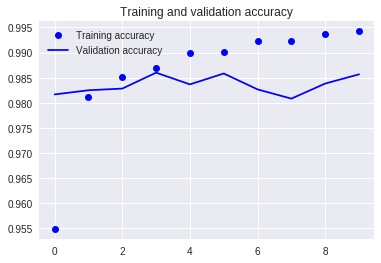

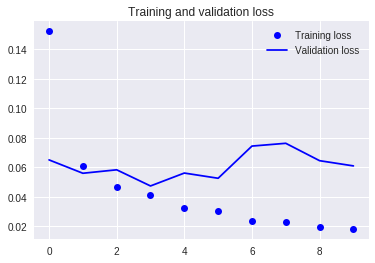

In [18]:
accuracy = mnist_train.history['acc']
val_accuracy = mnist_train.history['val_acc']
loss = mnist_train.history['loss']
val_loss = mnist_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Now let's predict the classes on test dataset and check which images were correctly classified and which images were misclassified**

In [0]:
predicted_classes = mnist_model.predict(test_X)

In [0]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

Found 9851 correct labels


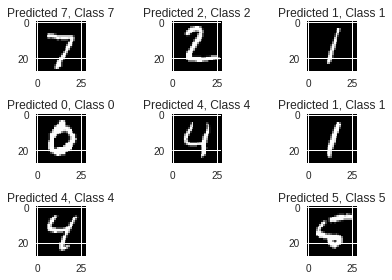

In [21]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_Y[correct]))
    plt.tight_layout()

Found 149 incorrect labels


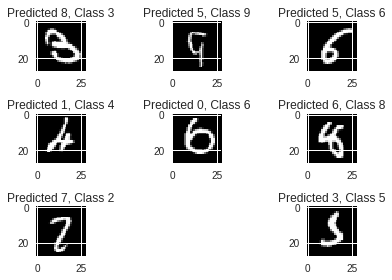

In [22]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_Y[incorrect]))
    plt.tight_layout()

# Model interpretability

**We now try to discern what our model is learning from the images. For this purpose, we make use of [SHAP](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) to interpret our model's learning process. For this, we need to install the package. The below code is inspired by the MNIST DeepExplainer example in the repository** 

In [23]:
!pip install -U shap

    100% |████████████████████████████████| 184kB 7.5MB/s 
  Running setup.py bdist_wheel for shap ... - \ | / - \ done
  Stored in directory: /root/.cache/pip/wheels/ef/55/5e/1b7fab6740a33bcae0de4938c110a9149d7e3f590b4f4510bf
Successfully built shap


In [0]:
import shap
import numpy as np

# Let's select a set of background examples to take an expectation over
background = train_X[np.random.choice(train_X.shape[0], 100, replace=False)]

# explain predictions of the model on three images
e = shap.DeepExplainer(mnist_model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(test_X[1:5])


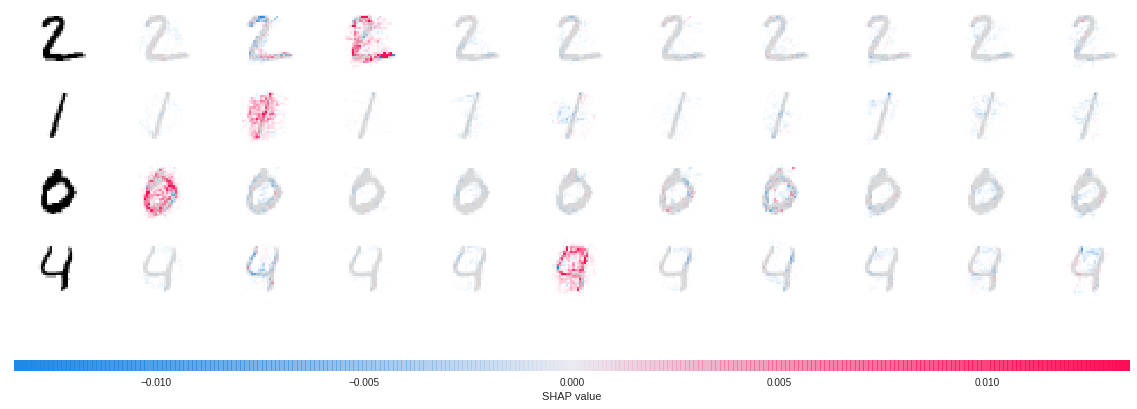

In [26]:
# plot the feature attributions
shap.image_plot(shap_values, -test_X[1:5])

**We will now fetch the images of 2's by searching for 2's index and then filtering them.**

In [27]:
index_mask = np.where(test_Y_one_hot[:, 2])[0]
print(index_mask)
subset_mask = np.random.choice(index_mask, 10)
print(subset_mask)

[   1   35   38 ... 9980 9985 9995]
[1432 6820 5629 5879 7472 4113 2253  326 3004 7789]


In [0]:
original_images = test_X[subset_mask]
original_labels = test_Y_one_hot[subset_mask]

**Let's check the classes of the images we filtered and check if they are correctly predicted.**

In [0]:
predicted_2 = mnist_model.predict(original_images)

In [30]:
prediction_val = np.argmax(np.round(predicted_2),axis=1)
print("predictions", prediction_val)

predictions [2 2 2 2 2 2 2 2 2 2]


In [31]:
probabilities_val = mnist_model.predict_proba(original_images)
print ("probabilities", probabilities_val)

probabilities [[3.53593104e-13 3.80991002e-13 1.00000000e+00 4.68369308e-14
  8.57143519e-27 3.47276569e-26 2.88637857e-20 6.54025377e-14
  1.89038441e-14 3.76803840e-20]
 [1.50129420e-20 2.88279089e-09 1.00000000e+00 6.54036821e-17
  1.55580948e-18 5.40122412e-24 1.66225165e-26 2.64681072e-13
  3.71800935e-19 1.58705486e-22]
 [9.60489751e-20 1.48928307e-18 1.00000000e+00 1.16814837e-12
  5.53875019e-23 5.87205440e-26 1.01320831e-24 1.54747553e-18
  5.08340071e-11 1.74648330e-18]
 [7.70616549e-14 1.81541902e-12 9.99995589e-01 4.35685433e-06
  2.33921637e-20 9.82365204e-23 3.39357715e-16 4.43805894e-14
  8.22385346e-13 2.84633333e-22]
 [8.93682871e-12 2.85551154e-15 9.99961257e-01 2.10910556e-09
  6.52690966e-12 3.36229220e-15 2.59790521e-19 3.87836662e-05
  1.85215665e-09 2.50735901e-13]
 [6.77890539e-20 1.63015660e-11 9.99999881e-01 1.73604107e-07
  8.22618228e-16 3.15532018e-22 8.29826944e-22 3.98294314e-11
  2.68385730e-11 1.06607348e-18]
 [5.24280631e-14 1.45795417e-13 9.99999881e-

**Let's display the images and their predicted labels**

Correct label 2
Predicted label: 2
Confidence: 1.0


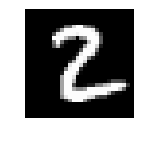

Correct label 2
Predicted label: 2
Confidence: 1.0


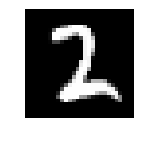

Correct label 2
Predicted label: 2
Confidence: 1.0


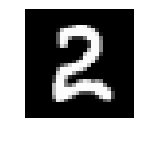

Correct label 2
Predicted label: 2
Confidence: 0.9999956


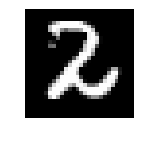

Correct label 2
Predicted label: 2
Confidence: 0.99996126


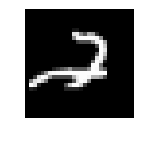

Correct label 2
Predicted label: 2
Confidence: 0.9999999


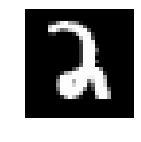

Correct label 2
Predicted label: 2
Confidence: 0.9999999


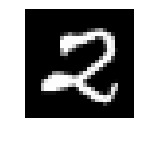

Correct label 2
Predicted label: 2
Confidence: 0.5960069


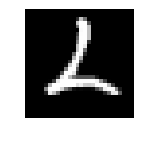

Correct label 2
Predicted label: 2
Confidence: 1.0


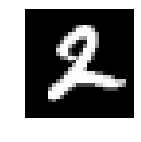

Correct label 2
Predicted label: 2
Confidence: 1.0


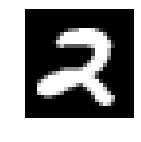

In [32]:
for i in range(0, 10):
    print('Correct label', np.argmax(original_labels[i]))
    print('Predicted label:', prediction_val[i])
    print('Confidence:', np.max(probabilities_val[i]))
    plt.figure(figsize=(2, 2))
    plt.axis('off')
    plt.imshow(original_images[i].reshape([28, 28]),cmap = "gray")
    plt.show()

**We now have to change the 2's images such that the model classifies the images as 6. For that reason, we set our target as 6 and initialize number of steps for running the calculation and epsilon value required for FGSM technique**

In [0]:
target_number = 6
n_steps = 10
eps = 0.5
adversarial_images = original_images.copy()

**Here, we are converting the target number to one-hot encoded vector. Then, use the vector to calculate the loss value. This loss value will be used to calculate the value of gradient. Finally, the gradient value will be used to create our adversarial examples.**

In [34]:
from keras import backend as K

adv_img_hist = list()
prob2_hist = list()
prob6_hist = list()

for i in range(n_steps):
  # Convert 6 to binary vector
  target = to_categorical(target_number)
  target_variable = K.variable(target)
  # Calculate Loss
  loss = keras.metrics.categorical_crossentropy(mnist_model.input, target_variable)
  # Obtain the value of gradient for creating adversarial example.
  gradients = K.gradients(loss, mnist_model.input)
  get_grad_values = K.function([mnist_model.input], gradients)
  grad_values = get_grad_values([adversarial_images])[0]
  # Create adversarial example by using the gradient values.
  adversarial_images = adversarial_images + eps * np.sign(grad_values)
  #Finally, clip the matrix to remove extra values.
  adversarial_images = np.clip(adversarial_images, a_min=0, a_max=1)
  adv_img_hist.append(adversarial_images)
  # We now try to predict the classes of these adversarial examples and their probability
  prediction = mnist_model.predict(adversarial_images)
  print("predictions", prediction_val)
  probs = mnist_model.predict_proba(adversarial_images)
  print('Confidence 2:', np.max(probs[:, 2]))
  print('Confidence 6:', np.max(probs[:, 6]))
prob2_hist.append(probs[:,2])
prob6_hist.append(probs[:,6])

predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 0.71688384
Confidence 6: 0.79933304
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05
predictions [2 2 2 2 2 2 2 2 2 2]
Confidence 2: 5.8044705e-24
Confidence 6: 1.868128e-05


**We now plot the original images, adversarial images and the gradient values in a grid**

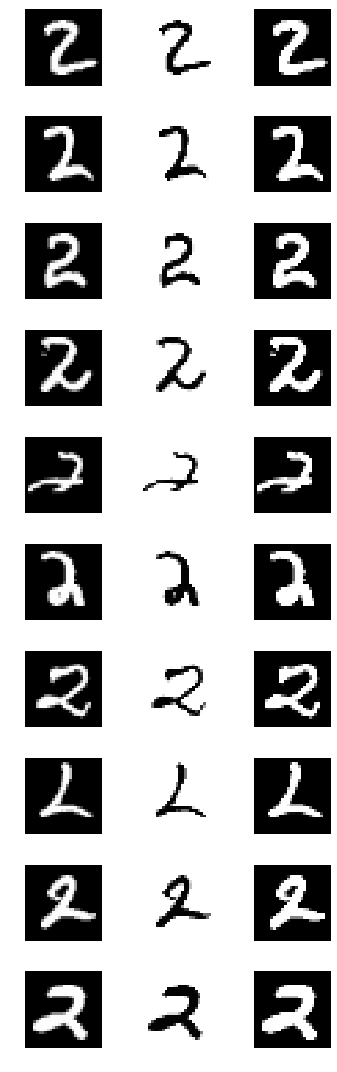

In [35]:
f, axarr = plt.subplots(10, 3, figsize=(5,15))
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 250
for i in range(10):
    axarr[i,0].set_axis_off()
    axarr[i,1].set_axis_off()
    axarr[i,2].set_axis_off()
    axarr[i,0].imshow(original_images[i].reshape([28, 28]), cmap = "gray")
    axarr[i,1].imshow((adv_img_hist[0][i] - original_images[i]).reshape([28, 28]), cmap = "gray")
    axarr[i,2].imshow((adv_img_hist[0][i]).reshape([28, 28]), cmap="gray")
    
plt.tight_layout()
plt.show()
f.savefig("result.png")